# Technical test for the data science internship @Hyperlex

Work done by **Alaa HOUIMEL** under 4 days

This notebook was made as a technical task for an internship @Hyperlex. The task consisted in analyzing an intial dataset of legal contracts, in which each contract is composed of different clauses. The exerice had 3 sub tasks:
1. Identify the different types of clauses using an unspervised approach
2. Extract the intra-cluster variation resulting after the previous step
3. (optional), based on the the previous work, train a clause classifier for new contracts


## Road map

This exercice covered a data science and end-to-end natural language processing pipeline, starting with **raw data** and running through **preparing**, **modeling**, **visualizing** and **analyzing** the data . We'll be doing :
* EDA of the dataset
* text processing with spaCy
    * tokenizing
    * dropping unnecessairy chars
    * lemmatizing
    * dropping stop words
* two-level phrase modeling (bigrams and trigrams)
* Topic modelling to cluster the data
    * LDA
    * NMF
    * K-means

* word embeddings (word2vec) => clause embeddings (clause2vec) for semantic analysis and scoring
* using the unspervised clustering labels to train a classifier for new data
    * Naive Bayes | SVM | multi-class logistic regression | XGBoost | etc

Let's get started 

In [738]:
import os
import warnings
warnings.filterwarnings('ignore')
import itertools as it
import codecs
import json
import numpy as np
import pandas as pd


# from nltk.tokenize import RegexpTokenizer , word_tokenize, sent_tokenize
# from nltk.stem.snowball import SnowballStemmer

#from nltk.corpus import stopwords
import spacy #be sure to use version 1.9.0
from gensim.models import Phrases
from gensim.models.phrases import Phraser  #it's faster according to gensim
from gensim.models.word2vec import LineSentence

import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [907]:
#!find . -iname *checkpoint* -type d -exec rm -r {} +  

## Importing Data

In [936]:
rootdir = 'dataset'
json_files = [os.path.join(dirpath, file) for dirpath,_,files in os.walk(rootdir) for file in files if file.endswith('json')]

contracts = []
for file in json_files:
    with open(file) as f:
        contracts.append(json.load(f)['clauses'][1:])  # starting from one to skip the summary since they contain different informations 
                                                  # and could affect the clustering
            
contracts_df = pd.DataFrame(contracts)

## EDA and Cleaning Data

In [937]:
# adding number of clauses colomn in contracts_df for later analysis
contracts_df['num_clauses'] = contracts_df.notna().sum(axis=1)

Text(0.5,1,'number of clauses per contract')

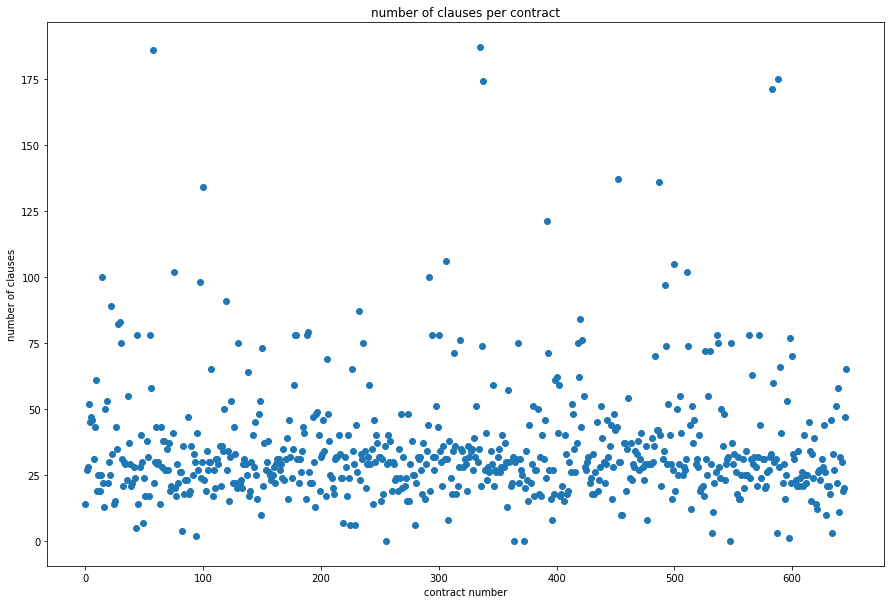

In [938]:
plt.figure(figsize=(15,10))
plt.scatter([range(contracts_df.shape[0])],contracts_df['num_clauses'])
plt.xlabel('contract number')
plt.ylabel('number of clauses')
plt.title('number of clauses per contract')

We can observe that we have some outliers in the corpus (probably due to bad parsing)
after observing the json files, I deemed it fit to just drop them (badly parsed)

In [939]:
contracts_df[contracts_df['num_clauses']<5] 

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,num_clauses
82,ARTICLE 1 FORME] La Société a été constituée s...,ARTICLE 5 La durée DUREE de la Société reste f...,ARTICLE 21 CONVENTIONS ENTRE LA SOCIETE ET SES...,ARTICLE 34 CAPITAUX PROPRES INFERIEURS A LA MO...,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,4
94,ARTICLE 2 OBJE La Société a pour objet : e La ...,ARTICLE 5 DUREE La durée de la Société est fix...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,2
255,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
364,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
372,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
532,14.1 Pouvoirs du Président Le Président assume...,ARTICLE 15. Directeur général. L associé uniqu...,ARTICLE 16. Rémunération du président et du di...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3
547,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0
587,ARTICLE 1 Il est formé à Paris une association...,ARTICLE 2 L association est ouverte a tout Isr...,ARTICLE 3 Le comité se réuni autant de fois qu...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3
597,CHAPITRE i : DEcisioNS COLLECTVES pneuen ronue...,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,1
634,ARTICLE 1 Il est formé à Paris une association...,ARTICLE 2 L association est ouverte à tout Isr...,ARTICLE 3 Le comité se réuni autant de fois qu...,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,3


In [940]:
contracts_df.drop(index=[82,94,255,364,372,547,597],inplace=True) #leave those with seemingly coherent structure

these specific contracts were dropped after manually checking them

In [941]:
contracts_df[contracts_df['num_clauses']>100]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,num_clauses
57,ARTICLE 1. FORME 3 ARTICLE 2. DENOMINATION SOC...,ARTICLE 1. 1.1 DENOMINATION OBJET SIEGE SOCIAL...,1.2 Elle fonctionne indifféremment sous la mêm...,ARTICLE 2. DÉNOMINATION SOCIALE,2.1 La dénomination sociale est : « SANTE CIE ».,2.2 Tous les actes et documents émanant de la ...,"ARTICLE 3. OBJET La Société a pour objet, dire...",ARTICLE 4. 4.1 SIEGE SOCIAL Le siège social de...,4.2 Il peut être transféré en tout autre endro...,ARTICLE 5. DUREE La durée de la Société est de...,...,1.2 Valeur vénale des titres de la Société La ...,1.3 Valeur de Marché des Actions Cédées La Val...,2.1 En cas de désaccord sur la Valeur de March...,2.2 L Expert devra déterminer la Valeur de Mar...,2.3 L Expert pourra avoir accès à tous les doc...,2.4 L Expert devra déterminer la Valeur de Mar...,2.5 La décision de l Expert liera définitiveme...,2.6 Les frais et dépenses relatifs à la déterm...,None,186
75,"ARTICLE 1 FORME La Société, de forme société p...",ARTICLE 2 DÉNOMINATION SOCIALE La dénomination...,"ARTICLE 3 OBJET La Société a pour objet, direc...",ARTICLE 4 SIÈGE SOCIAL Le siège social de la S...,ARTICLE S DURÉE La durée de la Société est de ...,"ARTICLE 6 APPORTS Lors de la constitution, les...",ARTICLE 7 CAPITAL SOCIAL Le capital social est...,ARTICLE 8 8.1 MODIFICATIONS DU CAPITAL SOCIAL ...,8.2 L associé unique ou la collectivité des as...,ARTICLE 9 9.1 Les LIBÉRATION DES ACTIONS actio...,...,None,None,None,None,None,None,None,None,None,102
100,ARTICLE 1. ARTICLE 2. ARTICLE 3. ARTICLE 4. AR...,ARTICLE 1. 1.1 DENOMINATION OBJET SIEGE SOCIAL...,1.2 Elle fonctionne indifféremment sous la mêm...,ARTICLE 2. DENOMINATION SOCIALE 2.1 La dénomin...,2.2 Tous les actes et documents émanant de la ...,"ARTICLE 3. OBJET La Société a pour objet, dire...",ARTICLE 4. SIEGE SOCIAL,4.1 Le siège social de la Société est fixé : 3...,4.2 Il peut être transféré en tout autre endro...,ARTICLE 5. DUREE La durée de la Société est de...,...,None,None,None,None,None,None,None,None,None,134
306,ARTICLE 2 DÉNOMINATION SOCIALE La dénomination...,"ARTICLE 3 OBJET La Société a pour objet, direc...",ARTICLE 4 SIÈGE SOCIAL Le siège social de la S...,ARTICLE 5 DURÉE La durée de la Société est de ...,ARTICLE 7 7.1 MODIFICATIONS DU CAPITAL SOCIAL ...,7.2 L associé unique ou la collectivité des as...,ARTICLE 8 8.1 Les LIBÉRATION DES ACTIONS actio...,8.2 Les appels de fonds sont portés à la conna...,"ARTICLE 9 FORME, CESSION ET TRANSMISSION DES A...",9.1 Les actions sont nominatives.,...,None,None,None,None,None,None,None,None,None,106
335,ARTICLE 2. DÉNOMINATION SOCIALE La dénominatio...,"ARTICLE 3. OBJET La Société a pour objet, dire...",ARTICLE 4. SIEGE SOCIAL Le siège social de la ...,"ARTICLE 5. DUREE La Société, sauf en cas de pr...",ARTICLE 7. CAPITAL SOCIAL Le capital social es...,ARTICLE 8. 8.1 MODIFICATIONS DU CAPITAL Le cap...,8.2 L associé unique ou la collectivité des as...,ARTICLE 9. LIBÉRATION DES ACTIONS,9.1 Les actions souscrites en numéraire doiven...,9.2 Les appels de fonds du surplus sont portés...,...,28.3 Pour les besoins de l article R.228 20 du...,28.4 Les Actions D rachetées seront annulées.,ARTICLE 29. CONTESTATIONS,"29.1 Toutes les contestations qui, pendant la ...","29.2 A cet effet, en cas de contestation, les ...",2.1 Détermination du Montant B1 Le Montant B1 ...,2.2 Détermination du Montant C Préalablement à...,2.3 Détermination du Montant B2 Le Montant B2 ...,1.1 Détermination du Montant Bl Le Montant B1 ...,187
338,ARTICLE 2 DÉNOMINATION SOCIALE La dénomination...,"ARTICLE 3 OBJET La Société a pour objet, direc...",ARTICLE 4 SIÈGE SOCIAL,4.1 Le siège social de la Société est fixé : 6...,4.2 Il peut être transféré en tout autre endro...,ARTICLE 5 DUREE La durée de la Société est de ...,ARTICLE 6 6.1 CAPITAL SOCIAL MODIFICATIONS DU ...,6.2 Aux terme des décisions de l associé uniqu...,6.3 Aux termes des décisions de l associé uniq...,ARTICLE 7 CAPITAL SOCIAL Le capit

In [942]:
contracts_df.loc[[57,100,587],0] = None # badly parsed

[Text(0,0.5,'number of clauses'),
 Text(0.5,0,'contract number'),
 Text(0.5,1,'number of clauses per contract')]

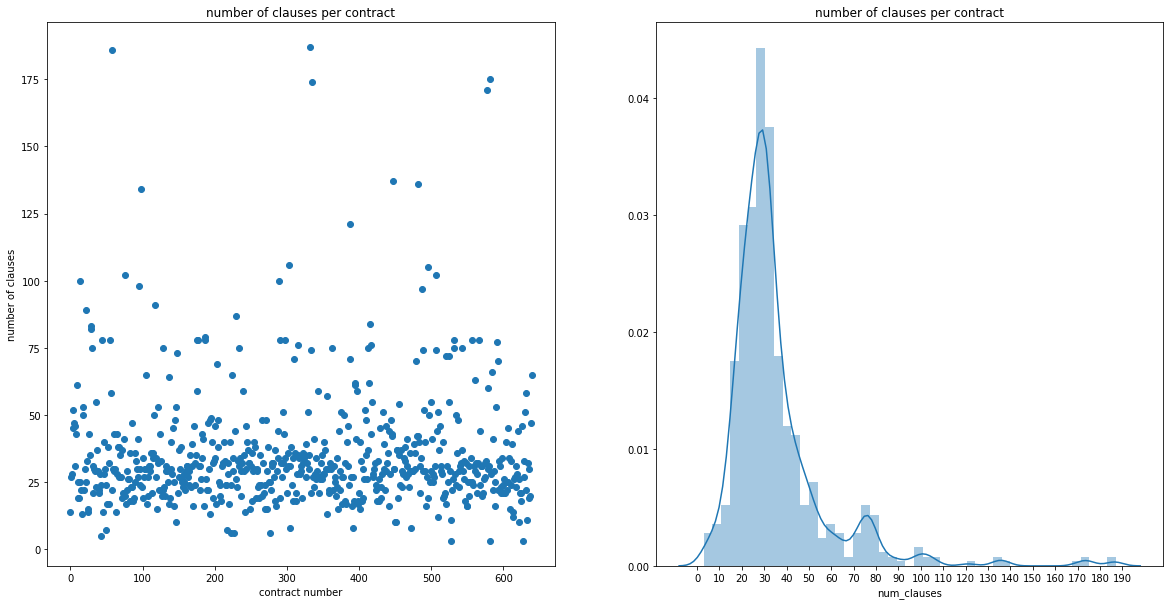

In [943]:

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[1].set(title='number of clauses per contract' )
ax[1].set_xticks(range(0,200,10))
sns.distplot(contracts_df['num_clauses'], ax=ax[1])

ax[0].scatter([range(contracts_df.shape[0])],contracts_df['num_clauses'])
ax[0].set(xlabel='contract number', ylabel='number of clauses', title='number of clauses per contract')


In [944]:
contracts_df.describe() #to have an idea about the number of clusters 

,num_clauses
count,640.000000
mean,35.585938
std,22.772718
min,3.000000
25%,23.000000
50%,30.000000
75%,40.000000
max,187.000000


we anticipate that the probable number of clusters would be something between 20 and 40

In [945]:
clauses_df = contracts_df.drop('num_clauses',axis=1).values.flatten()
clauses_df = clauses_df[clauses_df != np.array(None)]
clauses_df = pd.DataFrame(clauses_df)
clauses_df.describe()

,0
count,22772
unique,18982
top,"ARTICLE 10 FORME, CESSION ET TRANSMISSION DES ..."
freq,31


Although the duplicates won't affect the averaging used to find the kMeans centroids (for kmeans algorithm), I still decided to remove them because I only need unique descriptions to perform the clustering. Note that dropping duplicates will still keep one of those entries in the set.

In [946]:
clauses_df.drop_duplicates(inplace=True)
clauses_df.index = range(len(clauses_df.index)) # faster than reset_index
clauses_df.describe()

,0
count,18982
unique,18982
top,ARTICLE 17 Cessation d activité Retrait 1. Ces...
freq,1


In [947]:
clauses_df['length'] = clauses_df[0].str.len()

Text(0,0.5,'Clause length (in terms of words)')

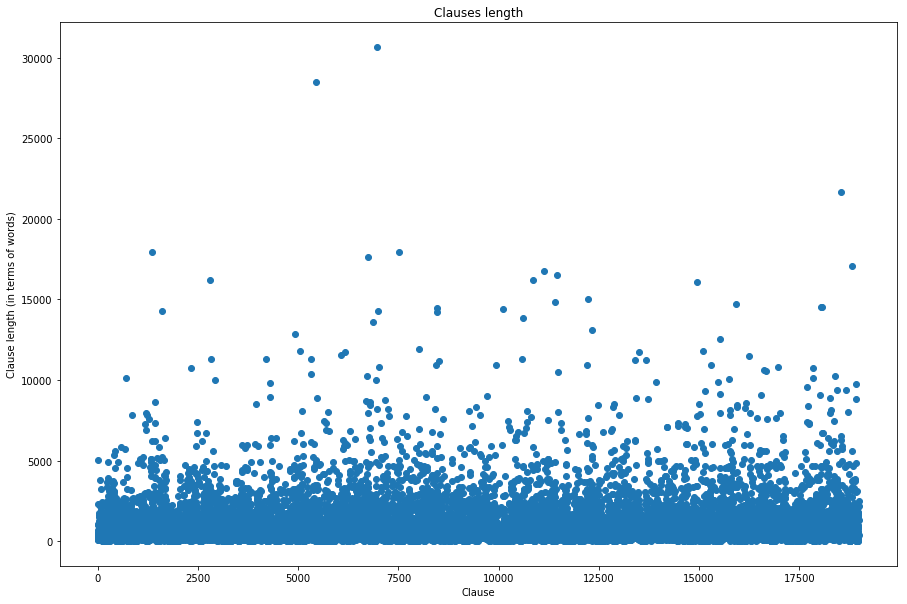

In [948]:
# clauses_lengths = [len(clause[0]) for clause in clauses_df.values]
# clauses_df['length'] = clauses_lengths
plt.figure(figsize=(15,10))
plt.scatter([range(len(clauses_df['length']))], clauses_df['length'].values)
plt.title('Clauses length')
plt.xlabel('Clause')
plt.ylabel(r'Clause length (in terms of words)')

here as well we can observe several outliers (either too short or too long). let's have a look at them

In [949]:
clauses_df.describe()

,length
count,18982.000000
mean,1010.983089
std,1327.896994
min,9.000000
25%,309.000000
50%,608.000000
75%,1221.000000
max,30657.000000


In [950]:
# the 16000 threshold was heuristically chosen after several observations of the article. this is when the main parsing problems begin
clauses_df[clauses_df.length > 16000].sort_values('length')

,0,length
14952,ARTICLE 17 Pouvoirs de la gérance En cas de pl...,16070
10856,Article 8 Capital social Le capital social est...,16180
2800,Article 12 1 Cession et transmission des parts...,16198
11465,ARTICLE 35. CONTESTATIONS Toutes contestations...,16540
11144,"22.3 Nonobstant ce qui précède, il pourra être...",16741
18805,19.1 Mode de consultation des associés Les ass...,17044
6741,"18.3 ""ounve ctrur eéng Le directeur général di...",17639
1341,4.3 Droit préférentiel de souscription En cas ...,17930
7524,"ARTICLE 12 SOUSCRIPTION, LIBERATION ET REPRESE...",17936
18553,"ARTICLE 11 SOUSCRIPTION, LIBERATION ET REPRESE...",21631


In [951]:
clauses_df.drop(clauses_df[clauses_df.length > 16000].index, inplace=True)

In [952]:
clauses_df[clauses_df.length < 15].sort_values('length')

,0,length
16158,8.1 Forme,9
14734,Article 6,9
9236,ARTICLE 9,9
7257,Article 9,9
13812,ARTICLE 19,10
11337,CHAPITRE 2,10
1752,ARTICLE 14,10
1789,ARTICLE 25,10
15783,ARTICLE 13,10
14769,Article 13,10


the problem with short parsed clauses is mainly because of the hierarchical presentation of some clauses 

1. clause x :

    1.1. line 1
    
    1.2. line 2
    
one way to solve this is to do some kind of inner correspondance of clauses inside the same article (that if we don't want to work directly with tons of regex to clean the dataset


Text(0,0.5,'Clause length (in terms of words)')

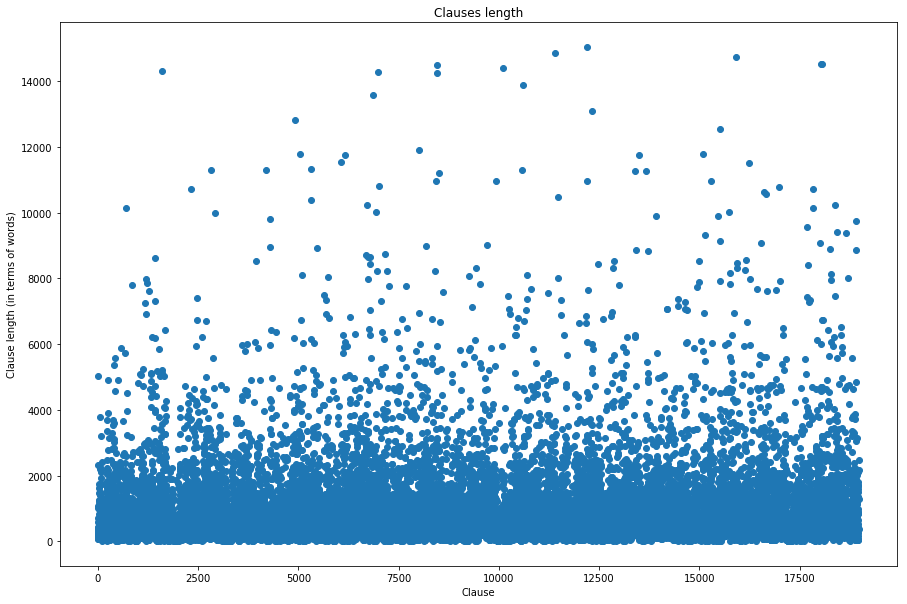

In [953]:
plt.figure(figsize=(15,10))
plt.scatter([range(len(clauses_df['length']))], clauses_df['length'].values)
plt.title('Clauses length')
plt.xlabel('Clause')
plt.ylabel(r'Clause length (in terms of words)')

## Processing pipeline :

**NOTES TO SELF**
before editing the data, we can extract the "labels" of each clause (for evaluation purposes)
1. **Tokenization** (nltk word tokenizer should be good)  . check out spacy as well  
2. possible way to clean data :
    * delete all numerical and alphanumerical words
    * delete "ARTICLE x.x"
    * delete punctuation
3. **lower case**
4. explore the possibility of combining some "special words" into n-grams
5. **lemmatization**
6. **stop words**
7. **Phrase Modeling** (unigrams, bigrams and trigrams)
8. **Save your work because your latop is nice to you** 

In [496]:
clauses = clauses_df[0].values   # faster and easier than to loop on a df

this part of the code was mainly based on this pretty detailed [example](https://github.com/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb)

In [497]:
%%time
nlp = spacy.load('fr')

Wall time: 7.2 s


### Phrase Modeling

_Phrase modeling_ is another approach to learning combinations of tokens that together represent meaningful multi-word concepts. We can develop phrase models by looping over the the words in our clauses and looking for words that _co-occur_ (i.e., appear one after another) together much more frequently than you would expect them to by random chance. The formula our phrase models will use to determine whether two tokens $A$ and $B$ constitute a phrase is:

$$\frac{count(A\ B) - count_{min}}{count(A) * count(B)} * N > threshold$$

...where:
* $count(A)$ is the number of times token $A$ appears in the corpus
* $count(B)$ is the number of times token $B$ appears in the corpus
* $count(A\ B)$ is the number of times the tokens $A\ B$ appear in the corpus *in order*
* $N$ is the total size of the corpus vocabulary
* $count_{min}$ is a user-defined parameter to ensure that accepted phrases occur a minimum number of times
* $threshold$ is a user-defined parameter to control how strong of a relationship between two tokens the model requires before accepting them as a phrase

Once our phrase model has been trained on our corpus, we can apply it to new text. When our model encounters two tokens in new text that identifies as a phrase, it will merge the two into a single new token. (and redo the same thing for 3 tokens)

As we're performing phrase modeling, we'll be doing some iterative data transformation at the same time. Our roadmap for data preparation includes:

1. Normalize text of clauses
1. First-order phrase modeling $\rightarrow$ _apply first-order phrase model to transform sentences_
1. Second-order phrase modeling $\rightarrow$ _apply second-order phrase model to transform sentences_
1. Apply text normalization and second-order phrase model to text of complete reviews

We'll use this transformed data as the input for some higher-level modeling approaches in the following sections.

First, let's define a few helper functions that we'll use for text normalization. In particular, the `lemmatized_sentence_corpus` generator function will use spaCy to:
- Iterate over the 18k (which is not that big) clauses
- Segment the clauses into individual sentences
- Remove punctuation and excess whitespace
- Lemmatize the text

... and do so efficiently in parallel, thanks to spaCy's `nlp.pipe()` function.

In [498]:
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

In [955]:
def filter_token(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space  or token.like_num or token.is_stop
            #or str(token).lower() == 'article'

def ram_saver(clauses):
    """
    helper function to transform the clauses list (iterator)
    into a generator
    """
    for clause in clauses:
        yield clause

# def lemmatized_sentence_corpus(clauses,lemmatizer = None ):
#     """
#     generator function to use spaCy to parse clauses,
#     lemmatize the text, and yield sentences
#     lemmatizer = provide a costum lemmatizer or use spacy's by default
#     """
    
#     for parsed_clause in nlp.pipe(ram_saver(clauses),
#                                   batch_size=512):
        
#         for sent in parsed_clause.sents:
#             #yield ' '.join([token.lemma_ for token in sent if not filter(token)])
#             if lemmatizer :
#                 yield ' '.join([lemmatizer.lemmatize(token.text) for token in sent 
#                             if not filter_token(token)]) 
#             else :
#                 yield ' '.join([token.lemma_ for token in sent 
#                             if not filter_token(token)]) 
                
def lemmatized_token_corpus(clauses, lemmatizer = None ):
    """
    generator function to use spaCy to parse clauses,
    lemmatize the text, and yield tokenzid clauses
    lemmatizer = provide a costum lemmatizer or use spacy's by default
    """
    
    for parsed_clause in nlp.pipe(ram_saver(clauses),
                                  batch_size=512):
        
        tokenized_clause = []
        for token in parsed_clause:
            #yield ' '.join([token.lemma_ for token in sent if not filter(token)])
            if lemmatizer :
                if not filter_token(token) :
                    tokenized_clause.append(lemmatizer.lemmatize(token.text))
            else :
                if not filter_token(token) :
                     tokenized_clause.append(token.lemma_)
        yield ' '.join(tokenized_clause)
                

In [956]:
intermediate_directory = os.path.join('.', 'intermediate') # this folder is where I save all the intermediate files
unigram_clauses_filepath = os.path.join(intermediate_directory,
                                          'unigram_clauses.txt')

In [957]:
%%time

# the if statement is avoid running the same code ,but read from disk instead
if False:

    with codecs.open(unigram_clauses_filepath, 'w', encoding='utf_8') as f:
        for tokenized_clause in lemmatized_token_corpus(clauses, FrenchLefffLemmatizer()):
            f.write(tokenized_clause + '\n')

Wall time: 13min 47s


since our `unigram_sentences_all` file now is  a large text file with one document/sentence per line , gensim's [**LineSentence**](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.LineSentence) class provides a convenient iterator for working with other gensim components. It *streams* the documents/sentences from disk, so that we never have to hold the entire corpus in RAM at once. This allows us to scale our modeling pipeline up to potentially very large corpora.

In [958]:
unigram_clauses = LineSentence(unigram_clauses_filepath)

In [959]:
for unigram_clause in it.islice(unigram_clauses, 230, 240):
    print( ' '.join(unigram_clause))
    print()

article consultation écrite En cas consultation correspondance consultation effectuée télécopie transmission électronique texte résolution proposées bulletin vote correspondant document nécessaire l information associé adressés demandeur associé moyens communication écrite télécopie courriel Les associé disposent d délai jour compter réception projet résolution adresser vote bulletin vote demandeur Le vote émis moyens communication écrite télécopie courriel si vote associé reçu l expiration dudit délai résolution(s concernée(s sera(ont réputée(s l objet d vote date réception vote la décision collective associé l objet d procès verbal établi signé demandeur annexe figurent réponse reçu associé contenant indication + mode consultation e Pidentité associé répondu texte résolution résultat vote résolution proposée e liste document rapport transmis associé Ce procès verbal immédiatement communiqué société conservé

article acte seing privé la décision associé s exprimer forme d acte seing p

In [960]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')

In [961]:
%%time
if False:
    bigram_model = Phraser(Phrases(unigram_clauses));

    bigram_model.save(bigram_model_filepath)
#load the finished model from disk
bigram_model = Phraser.load(bigram_model_filepath)

Wall time: 5.42 s


Now that we have a trained phrase model for word pairs, let's apply it to the clauses data and explore the results.

In [962]:
bigram_clauses_filepath = os.path.join(intermediate_directory,
                                         'bigram_clauses.txt')

In [963]:
%%time
if True:
    with codecs.open(bigram_clauses_filepath, 'w', encoding='utf_8') as f:

        for unigram_clause in unigram_clauses:

            bigram_clause = ' '.join(bigram_model[unigram_clause])

            f.write(bigram_clause + '\n')

Wall time: 0 ns


In [514]:
bigram_clauses = LineSentence(bigram_clauses_filepath)

In [515]:
for bigram_clause in it.islice(bigram_clauses, 230, 240):
    print (u' '.join(bigram_clause))
    print (u'')

2019-01-29 01:29:54,090 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\bigram_clauses.txt'}
article consultation_écrite En_cas consultation_correspondance consultation effectuée télécopie_transmission électronique texte_résolution proposées_bulletin vote correspondant document_nécessaire l information associé adressés demandeur associé moyens_communication écrite_télécopie courriel Les associé disposent d délai jour compter réception_projet résolution adresser vote bulletin_vote demandeur Le vote_émis moyens_communication écrite_télécopie courriel si vote associé reçu l expiration_dudit délai résolution(s concernée(s sera(ont réputée(s l objet d vote date réception vote la décision_collective associé l objet d procès_verbal établi_signé demandeur annexe figurent réponse reçu associé contenant_indication + mode_consultation e Pidentité associé répondu texte_résolution résultat vote résolution_proposée e liste_document rapport transmis associé Ce 

In [516]:
trigram_model_filepath = os.path.join(intermediate_directory,
                                      'trigram_model_all')

In [517]:
%%time
if False :
    trigram_model = Phraser(Phrases(bigram_clauses))

    trigram_model.save(trigram_model_filepath)

#load the finished model from disk
trigram_model = Phraser.load(trigram_model_filepath)

2019-01-29 01:29:54,133 - gensim.models.phrases - INFO - collecting all words and their counts
2019-01-29 01:29:54,134 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\bigram_clauses.txt'}
2019-01-29 01:29:54,137 - gensim.models.phrases - INFO - PROGRESS: at sentence #0, processed 0 words and 0 word types
2019-01-29 01:29:55,502 - gensim.models.phrases - INFO - PROGRESS: at sentence #10000, processed 695536 words and 174364 word types
2019-01-29 01:29:56,758 - gensim.models.phrases - INFO - collected 267009 word types from a corpus of 1349926 words (unigram + bigrams) and 18970 sentences
2019-01-29 01:29:56,759 - gensim.models.phrases - INFO - using 267009 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2019-01-29 01:29:56,760 - gensim.models.phrases - INFO - source_vocab length 267009
2019-01-29 01:30:00,249 - gensim.models.phrases - INFO - Phraser built with 27924 27924 phrasegrams
2019-01-29 01:30:00,26

We'll apply our trained second-order phrase model to our first-order transformed sentences, write the results out to a new file, and explore a few of the second-order transformed sentences.

In [366]:
trigram_clauses_filepath = os.path.join(intermediate_directory,
                                          'trigram_clauses.txt')

In [518]:
%%time

if False :
    with codecs.open(trigram_clauses_filepath, 'w', encoding='utf_8') as f:

        for bigram_clause in bigram_clauses:

            trigram_clause = ' '.join(trigram_model[bigram_clause])

            f.write(trigram_clause + '\n')

2019-01-29 01:30:00,450 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\bigram_clauses.txt'}
Wall time: 3.88 s


In [519]:
trigram_clauses = LineSentence(trigram_clauses_filepath)

In [520]:
for trigram_clause in it.islice(trigram_clauses, 230, 240):
    print (u' '.join(trigram_clause))
    print (u'')

2019-01-29 01:30:04,355 - smart_open.smart_open_lib - DEBUG - {'kw': {}, 'mode': 'rb', 'uri': '.\\intermediate\\trigram_transformed_clauses_all.txt'}
article consultation_écrite En_cas_consultation_correspondance consultation effectuée télécopie_transmission_électronique texte_résolution_proposées_bulletin vote correspondant document_nécessaire l information associé adressés demandeur associé moyens_communication_écrite_télécopie courriel Les associé disposent d délai jour_compter réception_projet_résolution adresser vote bulletin_vote demandeur Le vote_émis moyens_communication_écrite_télécopie courriel si vote associé reçu l expiration_dudit_délai résolution(s concernée(s sera(ont réputée(s l objet d vote date_réception vote la décision_collective associé l objet d procès_verbal_établi_signé demandeur annexe figurent réponse reçu associé contenant_indication + mode_consultation e Pidentité associé répondu texte_résolution résultat_vote résolution_proposée e liste_document_rapport tra

The final step of our text preparation process circles back to the complete text of the clauses. We're going to run the complete text of the clauses through a pipeline that applies our text normalization and phrase models.
we'll also remove stopwords at this point

In [371]:
trigram_clauses_filepath = os.path.join(intermediate_directory,
                                        'trigram_transformed_clauses_all.txt')

In [965]:
%%time
if True :
    with codecs.open(trigram_clauses_filepath, 'w', encoding='utf_8') as f:
        
        for tokenized_clause in  unigram_clauses:
            # lemmatize the text, removing punctuation and whitespace
            unigram_clause = tokenized_clause
            # apply the first-order and second-order phrase models
            bigram_clause = bigram_model[unigram_clause]
            trigram_clause = trigram_model[bigram_clause]

            # remove any remaining stopwords and words that are too short (parsing problems)
            trigram_clause = [term.lower() for term in trigram_clause
                              if term.lower() not in spacy.lang.fr.STOP_WORDS and len(term)>2]

            # write the transformed clause as a line in the new file
            trigram_clause = ' '.join(trigram_clause)
            f.write(trigram_clause + '\n')

Wall time: 8.62 s


In [966]:
print( 'Original:' + '\n')

for clause in it.islice(clauses, 11, 12):
    print (clause)

print ('----' + '\n')
print ('Transformed:' + '\n')

with codecs.open(trigram_clauses_filepath, encoding='utf_8') as f:
    for clause in it.islice(f, 11, 12):
        print (clause)

Original:

ARTICLE 13 1 Droits des associés ou de l associé unique Droits attribués aux parts Chaque part donne droit à une fraction des bénéfices et de l actif social proportionnellement au nombre de parts existantes. 2 Transmission des droits Les droits et obligations attachés aux parts les suivent dans quelque main qu elles passent. La propriété d une part emporte de plein droit adhésion aux statuts et aux résolutions réguliérement prises par les associés. Les représentants, peuvent, sous ayants quelque droit, prétexte conjoint que ce et soit, héritiers requérir d un associé l apposition ne des scellés sur les biens et valeurs de la société, ni en demander le partage ou la licitation. 3 Nantissement des parts Si la société a donné son consentement à un projet de nantissement de parts sociales, ce consentement emportera l agrément du cessionnaire en cas de réalisation forcée des parts nanties, selon ces conditions de l article 2078 du Code civil, à moins que la société ne préfère, ap

## Topic Modeling with Latent Dirichlet Allocation (_LDA_)

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics.

LDA is fully unsupervised. The topics are "discovered" automatically from the data by trying to maximize the likelihood of observing the documents in your corpus, given the modeling assumptions. They are expected to capture some latent structure and organization within the documents, and often have a meaningful human interpretation for people familiar with the subject material.

In the exercice's information, It is mentioned that a clause is the structural unit of a contract, and that each clause "generally" deals with one specific topic. That being said and knowing that LDA is a "soft" clustering algorithm, a first intuition would be to opt for a "hard" clustering algorithm , like K-means. But since I encountred some hierarchical clauses structures in the data, and I wasn't sure to what extent that "generally" was referring to, I decided to start with this topic modelling algorithm and work my analysis from there

We'll again turn to gensim to assist with data preparation and modeling. In particular, gensim offers a high-performance parallelized implementation of LDA with its [**LdaMulticore**](https://radimrehurek.com/gensim/models/ldamulticore.html) class.

In [650]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaModel

import pyLDAvis
import pyLDAvis.gensim
import pickle

The first step to creating an LDA model is to learn the full vocabulary of the corpus to be modeled. We'll use gensim's **Dictionary** class for this.

In [524]:
trigram_dictionary_filepath = os.path.join(intermediate_directory,
                                           'trigram_dict_all.dict')

In [967]:
%%time
import logging, sys
logging.disable(sys.maxsize)

if True:

    trigram_clauses = LineSentence(trigram_clauses_filepath)

    # learn the dictionary by iterating over all of the clauses
    trigram_dictionary = Dictionary(trigram_clauses)
    
    # filter tokens that are very rare or too common from
    # the dictionary (filter_extremes) and reassign integer ids (compactify)
    trigram_dictionary.filter_extremes(no_below=20, no_above=0.2)
    trigram_dictionary.compactify()

    trigram_dictionary.save(trigram_dictionary_filepath)
    
# load the finished dictionary from disk
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

Wall time: 1.4 s


Like many NLP techniques, LDA uses a simplifying assumption known as the [*bag-of-words* model](https://en.wikipedia.org/wiki/Bag-of-words_model). In the bag-of-words model, a document is represented by the counts of distinct terms that occur within it. Additional information, such as word order, is discarded. 

Using the gensim Dictionary we learned to generate a bag-of-words representation for each clause. The `trigram_bow_generator` function implements this. We'll save the resulting bag-of-words clauses as a matrix.

In the following code, "bag-of-words" is abbreviated as `bow`.

In [968]:
len(trigram_dictionary)

5358

our clauses corpus yielded a vocabulary with 5358

In [652]:
trigram_bow_filepath = os.path.join(intermediate_directory,
                                    'trigram_bow_corpus_all.mm')

In [653]:
def trigram_bow_generator(filepath):
    """
    generator function to read clauses from a file
    and yield a bag-of-words representation
    """
    
    for clause in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(clause)

In [969]:
%%time

if True:

    # generate bag-of-words representations for
    # all clauses and save them as a matrix
    MmCorpus.serialize(trigram_bow_filepath,
                       trigram_bow_generator(trigram_clauses_filepath))
    
# load the finished bag-of-words corpus from disk
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

Wall time: 1.8 s


With the bag-of-words corpus, we're finally ready to learn our topic model from the clauses. We simply need to pass the bag-of-words matrix and Dictionary from our previous steps to `LdaMulticore` as inputs, along with the number of topics the model should learn.

In [655]:
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')

In [971]:
%%time


if True:

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # workers => sets the parallelism, and should be
        # set to your number of physical cores minus one
        lda = LdaModel(trigram_bow_corpus,
                           num_topics=25,
                           id2word=trigram_dictionary)
    lda.save(lda_model_filepath)
    
# load the finished LDA model from disk
lda = LdaModel.load(lda_model_filepath)

Wall time: 7.62 s


Our topic model is now trained and ready to use! Since each topic is represented as a mixture of tokens, we can manually inspect which tokens have been grouped together into which topics to try to understand the patterns the model has discovered in the data.

In [927]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print (u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda.show_topic(topic_number, topn=topn):
        print (u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [972]:
explore_topic(topic_number=1)

term                 frequency

actionnaire          0.054
nomination           0.032
commissaire_compte   0.029
mandat               0.017
représentant         0.014
ordinaire            0.014
fonction             0.013
gérant               0.013
nommés               0.012
cas                  0.012
commissaire_aux_compte 0.012
collectivité         0.011
administrateur       0.010
exercice             0.009
révocation           0.009
décision_collective_ordinaire 0.008
désignés             0.008
décision_collective  0.007
commissaire_compte_titulaire 0.007
comité               0.007
compte               0.007
nommé                0.006
incapacité           0.006
responsabilité       0.006
décidée              0.006


* one idea here is to manually give a label to each cluster to help organise the clauses, but I believe the input of a person with some legal background would give more thourough results

Manually reviewing the top terms for each topic is a helpful exercise, but to get a deeper understanding of the topics and how they relate to each other, we need to visualize the data &mdash; preferably in an interactive format. Fortunately, we have the fantastic [**pyLDAvis**](https://pyldavis.readthedocs.io/en/latest/readme.html) library to help with that!

pyLDAvis includes a one-line function to take topic models created with gensim and prepare their data for visualization.

In [973]:
LDAvis_data_filepath = os.path.join(intermediate_directory, 'ldavis_prepared.pkl')

In [976]:
%%time

if True:

    LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus,
                                              trigram_dictionary)

    with open(LDAvis_data_filepath, 'wb') as f: #binary mode
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:  # binary mode
    LDAvis_prepared = pickle.load(f)

Wall time: 10.1 s


In [977]:
pyLDAvis.display(LDAvis_prepared)

* Setting the $\lambda$ parameter close to 1.0 (the default) will rank the terms solely according to their probability within the topic.
* Setting $\lambda$ close to 0.0 will rank the terms solely according to their "distinctiveness" or "exclusivity" within the topic &mdash; i.e., terms that occur *only* in this topic, and do not occur in other topics.
* Setting $\lambda$ to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and exclusivity accordingly.

The interactive visualization pyLDAvis produces is helpful for both:
1. Better understanding and interpreting individual topics, and
1. Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most freqeuent and/or "relevant" terms, using different values of the $\lambda$ parameter. This can help when you're trying to assign a human interpretable name or "meaning" to each topic.

For (2), exploring the _Intertopic Distance Plot_ can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The `format_topics_sentences()` function below nicely aggregates this information in a presentable table.

In [978]:
trigram_clauses_text = [' '.join(trigram_clause) for trigram_clause in trigram_clauses]

In [979]:
def format_topics_sentences(ldamodel=lda, corpus=trigram_bow_corpus, texts=trigram_clauses_text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [770]:
df_dominant_topic_filename = os.path.join(intermediate_directory, 'df_dominant_topic')

if False : 
    with open(df_dominant_topic_filename, 'wb') as f:
        df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=trigram_bow_corpus, texts=trigram_clauses_text)

        # Format
        df_dominant_topic = df_topic_sents_keywords.reset_index()
        df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
        
        pickle.dump(df_dominant_topic, f)
        
with open(df_dominant_topic_filename, 'rb') as f:
    df_dominant_topic = pickle.load(f)

In [792]:
# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,26.0,0.4235,"ordinaire, compte, délibération, assemblée_gén...",article forme société entreprise_unipersonnell...
1,1,7.0,0.9753,"objet, conseil, administration, titre, filiale...",article objet société objet_france étranger ve...
2,2,11.0,0.7308,"dénomination, forme, disposition, document_éma...",article dénomination dénomination société ads ...
3,3,8.0,0.5939,"part, euro, apport, part_sociale, monsieur, au...",article siège_social siège_social_fixé_rue jea...
4,4,6.0,0.8622,"durée, apport, somme_euro, commerce, immatricu...",article durée durée société fixée_année_compte...
5,5,21.0,0.6430,"exercice, transformation, commissaire_compte, ...",article exercice social exercice social_commen...
6,6,8.0,0.4551,"part, euro, apport, part_sociale, monsieur, au...",article apport clovis sarl capital puteaux imm...
7,7,8.0,0.4005,"part, euro, apport, part_sociale, monsieur, au...",article augmentation_réduction_capital social ...
8,8,22.0,0.9036,"part_sociale, part, ordinaire, prise, extraord...",article représentation part_sociale part_socia...
9,9,18.0,0.9643,"agrément, cession, part, cédant, demande, déla...",article cession_transmission part_sociale form...


let's have a look on a specific topic and manually assess the relevance of the most contributing clauses

In [765]:
df_dominant_topic[df_dominant_topic.Dominant_Topic == 5.0].sort_values('Topic_Perc_Contrib', ascending=0).head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
398,398,5.0,0.9459,"prise, entreprise, investisseur, jour_date, jo...",article modalites_de_transmission_des action a...
8293,8293,5.0,0.9454,"prise, entreprise, investisseur, jour_date, jo...",article modalites_de_transmission_des action a...
14404,14404,5.0,0.9451,"prise, entreprise, investisseur, jour_date, jo...",article modalites_de_transmission_des action a...
8820,8820,5.0,0.9448,"prise, entreprise, investisseur, jour_date, jo...",article modalites_de_transmission_des action a...
251,251,5.0,0.9432,"prise, entreprise, investisseur, jour_date, jo...",article modalites_de_transmission_des action a...
5414,5414,5.0,0.9320,"prise, entreprise, investisseur, jour_date, jo...",article modalites_de_transmission_des action a...
9370,9370,5.0,0.9217,"prise, entreprise, investisseur, jour_date, jo...",article modalites_de_transmission_des action a...
2696,2696,5.0,0.8798,"prise, entreprise, investisseur, jour_date, jo...",article modalites_de_transmission_des action t...
1580,1580,5.0,0.8523,"prise, entreprise, investisseur, jour_date, jo...",article décision objet des_decisions_collectiv...
11657,11657,5.0,0.8414,"prise, entreprise, investisseur, jour_date, jo...",article transfert action sou_réserve dispositi...


## Topic modelling with Non Negative Matrix Facturization (NMF)

While LDA and NMF have differing mathematical underpinning, both algorithms are able to return the documents that belong to a topic in a corpus and the words that belong to a topic. LDA is based on **Probabilstic Graphical Models** while NMF relies on **Linera Algebra**. Both algorithms take as input a bag of words matrix (i.e., each document represented as a row, with each columns containing the count of words in the corpus). The aim of each algorithm is then to produce 2 smaller matrices; a document to topic matrix and a word to topic matrix that when multiplied together reproduce the bag of words matrix with the lowest error.


different than LDA (which uses a BOW = TF representation of the data), NMF uses TF-IDF

this part of the code is based on this [tutorial](https://github.com/derekgreene/topic-model-tutorial)

In [663]:
from sklearn.decomposition import NMF
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

Let's remember that our trigram_dictionary has 5358 words and our bow_corpus has 18967 clauses (and 5358 columns ofc)

In [980]:
model_tfidf = TfidfModel(trigram_bow_corpus, id2word=trigram_dictionary)
clauses_tfidf_object =   model_tfidf[trigram_bow_corpus]
clauses_tfidf = np.vstack([sparse2full(clause, len(trigram_dictionary)) for clause in clauses_tfidf_object])

In [981]:
clauses_tfidf.shape

(18967, 5358)

the resulting `clauses_tfidf` is also a matrix with 18967 rows (clauses) and 5358 columns (TF-IDF terms).

let's fit the NMF model with tf-idf features.

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of k.

We need to start by pre-specifying an initial range of "sensible" values (based on the inital plots of number of clauses per contract)

In [982]:
kmin, kmax = 20, 35

In [983]:
nmf_models_filepath = os.path.join(intermediate_directory,
                                         'nmf_models')

In [984]:
nmf_models = []
# try each value of k
if True :
    with open(nmf_models_filepath, 'wb') as f: #binary mode
        for k in range(kmin,kmax+1):
            print("Applying NMF for k=%d ..." % k )
            # run NMF
            model = NMF( init="nndsvd", n_components=k) 
            W = model.fit_transform( clauses_tfidf )
            H = model.components_
            # store for later
            nmf_models.append( (k,W,H) )
        pickle.dump(nmf_models, f)

Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...
Applying NMF for k=31 ...
Applying NMF for k=32 ...
Applying NMF for k=33 ...
Applying NMF for k=34 ...
Applying NMF for k=35 ...


The previous cell was executed two times , explaining the missing first values of k in the progress log

In [685]:
with open(nmf_models_filepath, 'rb') as f:  # binary mode
    nmf_models = pickle.load(f)

### Build  Word Embeddings

To select the number of topics, here we will use a topic coherence measure called TC-W2V. This measure relies on the use of a word embedding model constructed from our corpus. So in this step we will use the Gensim implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

another (probably better) way to do this is to train the word embeddings on a bigger dataset, or find ourselves pre-trained embeddings that are oriented to the legal domain

In [819]:
from gensim.models import Word2Vec

law2vec_filepath = os.path.join(intermediate_directory, 'law2vec_model_all')

In [671]:
import multiprocessing
multiprocessing.cpu_count()

8

In [985]:
%%time

if True :

    # initiate the model and perform the first epoch of training
    law2vec = Word2Vec(size=300, window=5,min_count=20, sg=1, workers=7)
    law2vec.build_vocab(trigram_clauses)
    law2vec.save(law2vec_filepath)
    law2vec.epochs =  1
    # perform another 19 epochs of training
    for i in range(1,20):
        law2vec.train(trigram_clauses ,epochs= law2vec.epochs , total_examples=law2vec.corpus_count)
        law2vec.save(law2vec_filepath)
        print (u'{} training epochs so far.'.format(law2vec.train_count))
# load the finished model from disk
law2vec = Word2Vec.load(law2vec_filepath)
law2vec.init_sims()

1 training epochs so far.
2 training epochs so far.
3 training epochs so far.
4 training epochs so far.
5 training epochs so far.
6 training epochs so far.
7 training epochs so far.
8 training epochs so far.
9 training epochs so far.
10 training epochs so far.
11 training epochs so far.
12 training epochs so far.
13 training epochs so far.
14 training epochs so far.
15 training epochs so far.
16 training epochs so far.
17 training epochs so far.
18 training epochs so far.
19 training epochs so far.
Wall time: 33.1 s


In [986]:
print (u'{:,} terms in the law2vec vocabulary.'.format(len(law2vec.wv.vocab)))

5,633 terms in the law2vec vocabulary.


Let's take a peek at the word vectors our model has learned. We'll create a pandas DataFrame with the terms as the row labels, and the 300 dimensions of the word vector model as the columns.

In [987]:
# build a list of the terms, integer indices,
# and term counts from the law2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count)
                 for term, voc in law2vec.wv.vocab.items()]
# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda x : -x[-1])  # x has shape (term, index, count)

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the law2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(law2vec.wv.syn0norm[term_indices, :],
                            index=ordered_terms)

word_vectors

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
associé,0.010535,0.006684,0.036373,-0.028898,-0.002412,0.012895,-0.019384,0.026787,0.074119,-0.044639,...,-0.000212,-0.004687,0.022012,0.010080,0.044598,0.011858,0.043498,-0.117347,-0.092386,0.044109
société,-0.059218,0.060788,-0.008761,0.025407,-0.045836,-0.087517,-0.075815,-0.104292,0.019910,0.018693,...,-0.061493,0.040801,0.043916,-0.050133,-0.051991,0.033781,0.025265,-0.065057,0.003063,-0.034849
article,-0.106529,-0.041848,0.055449,0.043285,-0.036029,0.002986,-0.064228,0.024996,0.053015,0.042358,...,-0.079753,0.057151,0.082157,-0.006106,-0.040619,-0.036262,-0.020141,-0.063004,0.036074,0.059260
président,-0.046958,0.057069,-0.069443,-0.022557,-0.078399,-0.043439,-0.011472,0.012710,-0.068135,-0.070859,...,0.041963,0.021804,-0.082361,0.000770,-0.053126,-0.006784,0.042203,-0.019911,0.008737,0.102195
décision,-0.029251,0.039693,0.053437,0.012831,-0.039329,0.035150,-0.001438,0.003813,0.016539,0.022255,...,0.011499,0.000053,-0.038745,-0.012975,0.022456,0.087049,-0.038045,0.017140,0.002352,0.069321
action,0.020447,-0.033444,-0.022361,0.019997,-0.120702,-0.092543,0.084088,0.065316,-0.008076,0.031210,...,-0.065060,-0.005757,-0.074141,-0.087249,-0.069202,0.125303,-0.036497,0.034068,-0.121517,0.034146
capital,0.041369,0.031499,-0.129413,0.036614,0.118782,0.074046,0.030729,0.088744,0.088030,0.024229,...,-0.023235,-0.097564,0.020457,0.006320,-0.027985,0.025716,0.058241,-0.055155,0.048641,-0.070710
social,0.110744,0.024359,-0.004439,0.162787,-0.148981,0.019641,0.042435,0.062915,0.133692,-0.026066,...,0.086218,-0.045675,0.075056,-0.045080,-0.071929,-0.000759,0.025743,-0.111435,-0.019661,-0.073063
part,-0.050914,0.015932,-0.007270,0.006227,0.010544,-0.017632,0.050114,0.061268,0.070516,-0.022177,...,-0.002400,-0.017166,-0.087284,0.009693,-0.050973,0.033856,0.047849,0.009376,-0.005324,0.070744
exercice,0.033369,0.035597,0.030521,0.047390,-0.043138,-0.028764,-0.036258,-0.037338,-0.012281,0.015346,...,-0.011495,-0.076557,-0.012041,0.050652,0.050955,-0.060847,0.011561,-0.005463,-0.021236,0.009330


## Word Vector Visualization with t-SNE

[t-Distributed Stochastic Neighbor Embedding](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf), or *t-SNE* for short, is a dimensionality reduction technique to assist with visualizing high-dimensional datasets. It attempts to map high-dimensional data onto a low two- or three-dimensional representation such that the relative distances between points are preserved as closely as possible in both high-dimensional and low-dimensional space.

scikit-learn provides a convenient implementation of the t-SNE algorithm with its [TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) class.

In [779]:
from sklearn.manifold import TSNE

Our input for t-SNE will be the DataFrame of word vectors we created before. Let's first:

In [988]:
tsne_input = word_vectors.drop(spacy.lang.fr.STOP_WORDS, errors=u'ignore')

In [989]:
tsne_input.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
associé,0.010535,0.006684,0.036373,-0.028898,-0.002412,0.012895,-0.019384,0.026787,0.074119,-0.044639,...,-0.000212,-0.004687,0.022012,0.010080,0.044598,0.011858,0.043498,-0.117347,-0.092386,0.044109
société,-0.059218,0.060788,-0.008761,0.025407,-0.045836,-0.087517,-0.075815,-0.104292,0.019910,0.018693,...,-0.061493,0.040801,0.043916,-0.050133,-0.051991,0.033781,0.025265,-0.065057,0.003063,-0.034849
article,-0.106529,-0.041848,0.055449,0.043285,-0.036029,0.002986,-0.064228,0.024996,0.053015,0.042358,...,-0.079753,0.057151,0.082157,-0.006106,-0.040619,-0.036262,-0.020141,-0.063004,0.036074,0.059260
président,-0.046958,0.057069,-0.069443,-0.022557,-0.078399,-0.043439,-0.011472,0.012710,-0.068135,-0.070859,...,0.041963,0.021804,-0.082361,0.000770,-0.053126,-0.006784,0.042203,-0.019911,0.008737,0.102195
décision,-0.029251,0.039693,0.053437,0.012831,-0.039329,0.035150,-0.001438,0.003813,0.016539,0.022255,...,0.011499,0.000053,-0.038745,-0.012975,0.022456,0.087049,-0.038045,0.017140,0.002352,0.069321


In [990]:
tsne_filepath = os.path.join(intermediate_directory,
                             u'tsne_model')

tsne_vectors_filepath = os.path.join(intermediate_directory,
                                     u'tsne_vectors.npy')

In [991]:
%%time

if True:
    
    tsne = TSNE()
    tsne_vectors = tsne.fit_transform(tsne_input.values)
    
    with open(tsne_filepath, 'wb') as f:
        pickle.dump(tsne, f)

    pd.np.save(tsne_vectors_filepath, tsne_vectors)
    
with open(tsne_filepath , 'rb') as f:
    tsne = pickle.load(f)
    
tsne_vectors = pd.np.load(tsne_vectors_filepath)

tsne_vectors = pd.DataFrame(tsne_vectors,
                            index=pd.Index(tsne_input.index),
                            columns=[u'x_coord', u'y_coord']) 

Wall time: 3min 5s


Now we have a two-dimensional representation of our data! Let's take a look.

### Plotting with Bokeh

In [992]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value

output_notebook()

Loading BokehJS ...

In [993]:
# add our DataFrame as a ColumnDataSource for Bokeh
plot_data = ColumnDataSource(tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
tsne_plot = figure(title=u't-SNE Word Embeddings',
                   plot_width = 800,
                   plot_height = 800,
                   tools= (u'pan, wheel_zoom, box_zoom,'
                           u'box_select, reset'),
                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
tsne_plot.add_tools( HoverTool(tooltips = u'@word') )

# draw the words as circles on the plot
tsne_plot.circle(u'x_coord', u'y_coord', source=plot_data,
                 color=u'blue', line_alpha=0.2, fill_alpha=0.1,
                 size=10, hover_line_color=u'black')

# configure visual elements of the plot
tsne_plot.title.text_font_size = value(u'16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None

# engage!
show(tsne_plot);

In [752]:
def get_related_terms(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """

    for word, similarity in law2vec.most_similar(positive=[token], topn=topn):

        print (u'{:20} {}'.format(word, round(similarity, 3)))

In [994]:
get_related_terms(u'capital')

distribuer_l_écart   0.508
somme_million_euro   0.466
proportionnel_quotité_capital 0.455
valeur_mobilieres_donnant_acces 0.453
décident_moi_suivent 0.449
action_préférence_majoration_montant 0.449
ii_divisé            0.448
n_imputées_réserve   0.446
il_incorporé_partie  0.443
nominal_titre        0.442


### Selecting the Number of Topics
Once we have our Word2vec model, we can use it as part of our topic coherence approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [995]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

from gensim.models

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [996]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

Now process each of the models for different values of k:

In [997]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in nmf_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( trigram_dictionary, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( law2vec, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=20: Coherence=0.3081
K=21: Coherence=0.3058
K=22: Coherence=0.3117
K=23: Coherence=0.3169
K=24: Coherence=0.3120
K=25: Coherence=0.3148
K=26: Coherence=0.3172
K=27: Coherence=0.3139
K=28: Coherence=0.3204
K=29: Coherence=0.3260
K=30: Coherence=0.3263
K=31: Coherence=0.3255
K=32: Coherence=0.3303
K=33: Coherence=0.3196
K=34: Coherence=0.3171
K=35: Coherence=0.3313


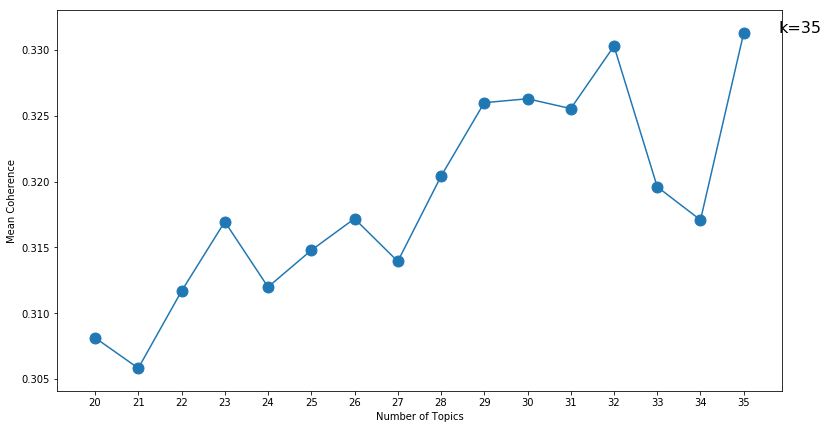

In [998]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

I reckon that this is not the best coherence curve that one can expect to have, but according to literature and articles online, cleaning and preprocessing the data can greatly affect the results of topic modeling algorithms

Another possible measure I encountered in the literature is model perplexity : the less the better


insider tip: let's re do the LDA model with this value ;)

In [999]:
k = best_k
# get the model that we generated earlier.
W = nmf_models[k-kmin][1]
H = nmf_models[k-kmin][2]

In [1000]:
for topic_index in range(k):
    descriptor = get_descriptor( trigram_dictionary, H, topic_index-12, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ),'\n' )

Topic 01: rémunération, fixée, collectivité, fonction, droit_remboursement_frai, conseil_surveillance, montant, représentation_déplacement, modalité, fixé 

Topic 02: inscription_compte, attestation, forme_des, compte, condition_modalité, titulaire, action_obligatoirement_nominatives, délivrée, action_résulte_inscription, individuel 

Topic 03: exclusion, exclu, concerné, lettre_recommandée_demande, cause, action_préférence, rachat, encontre, cession, procédure 

Topic 04: forme, présent_statut, action_simplifiée_régie_disposition, propriétaire, elle_procéder_offre, il_existe, présent_statut_elle_fonctionne, forme_il_formé, disposition, établi_seing_privé 

Topic 05: nu_propriétaire, usufruitier, égard, assemblée_générale, droit_vote_appartient, les_copropriétaire_indivis, ordinaire, part_sociale_indivisibles, usufruit, action_indivisibles 

Topic 06: fixé_somme_euro, catégorie, il_divisé, ordinaire, euro_valeur_nominale, euro_il_divisé, euro_entièrement_libéré, fixé, action_préférence

## Topic Modelling using K-means

Both K-means and Latent Dirichlet Allocation (LDA) (or NMF) are unsupervised learning algorithms, where the user needs to decide a priori the parameter K, respectively the number of clusters and the number of topics.

If both are applied to assign K topics to a set of N documents, the most evident difference is that K-means is going to partition the N documents in K disjoint clusters (i.e. topics in this case). On the other hand, LDA assigns a document to a mixture of topics : Hard clustering vs Soft clustering (like GMMs)

In [1001]:
word_vectors.shape

(5633, 300)

In [1002]:
clauses_tfidf.shape

(18967, 5358)

I construct a simple clause embedding (clause2vec) by summing the respective embeddings of its component tokens. Since this assumes that all tokens are of equal importance (which is a naive simplification), it would be wise to also include the option to weight tokens by their inverse clause frequency (~IDF from TFIDF). More investigation is needed.

ps: exponential decay is often used in practice, this could be experimented with.

Something else to be aware of is that different length clauses will cause clause embeddings of different magnitudes. Usually in data mining, the similarity between two vector embeddings is calculated using cosine similarity (which is equivalent to normalising the vectors and then taking the dot product). Whether normalisation is needed or not in this application is up for discussion (could argue that some clustering techniques are robust to this effect), but it is also included as an option.

In [964]:
clauses_vectors_df_filename = os.path.join(intermediate_directory, 'clauses_vectors_df')

if False:  
    with open(clauses_vectors_df_filename , 'wb') as f:
        clauses_vectors = []
        for clause in clauses_list:
            vect = [0]*300
            for word in clause:
                if word in word_vectors.index :
                    vect += word_vectors.loc[word] # should be weighted by the corresponding IDF value
                    # which would have been fairly straightforward if we were handling matrices  directly instead of gensim objects
                    # scikit learn wins this one
            clauses_vectors.append(vect/len)
        clauses_vectors_df = pd.DataFrame(np.reshape(clauses_vectors, (len(clauses_vectors),300)))
        pickle.dump(clauses_vectors_df,f)
        
with open(clauses_vectors_df_filename, 'rb') as f :
    clauses_vectors_df =  pickle.load(f)

In [885]:
clauses_vectors_df.shape

(18967, 300)

In [887]:
from sklearn.metrics.pairwise import cosine_similarity

In [899]:
cosine_similarity(np.array(clauses_vectors_df.loc[0]).reshape(1,-1),
                  np.array(clauses_vectors_df.loc[1]).reshape(1,-1)) # just testing

array([[0.12678852]])

Another path for enhancing the model is spectral clustering. Its advantages over other techniques (such as k-means approaches) include robustness to both "non-spherical" and non-uniform-density clusters.

There might need to be consideration regarding normalising feature vectors (since different length clauses will have different size feature vectors). If we think in two dimensions only, then normalising feature vectors would simply map all data points to the circumference of a unit circle (could be easy to identify clusters of points). Alternatively, without normalisation then data points could be anywhere in the space - in my understanding, spectral clustering would still be able to identify the 'correct' clusters of points.
With more time to test the results, I would look further into this.

**Additional ideas**:

* Intra-contract clause-clustering
    * The "clauses" identified in the preprocessing stage could be clauses, sub-clauses or false positives. It could be useful to first cluster the identified clauses in each contract before comparing across each contract (the desired effect would be to group together sub-clauses and drop false positives)
* Bootstrapping to be more robust to outliers?
* Cluster data points from all contract types to understand extend understanding

### Evaluation of the models

This task was just to design and implement a  ML pipeline for clause clustering . All algorithm choices (clause extraction, text processing and normalization, feature extraction, clustering method) could be swapped out for more suitable approaches in the future.

"More suitable" could of course be defined in terms of computational complexity, but really in this context, we need some measure of suitability in terms of the clause clusters identified.

In the unsupervised setting, this can sometimes be hard to define - below I briefly introduce some thoughts regarding defining performance metrics:

* Loss function for the clustering algorithm.
* Generate a language model for each identified cluster. For an unseen contract, what is the probability that its clauses were generated by the cluster language models?
* Identify discriminative words in each cluster found. Compare against some prior knowledge such as what a lawyer looks at when drafting an Employment contract (if there is such thing!).

---

## Semantic analysis to extraction variation inside a cluster
First of all, I would like to stress the fact that "with clean data, comes great responsibility, and thus clean results". So even if we had the cleanest data to start with, given the nature of some clauses (e.g. "OBJECT"), we'd stil end up with some variations in the clusters. But with badly parsed data incorporating a lot of noisy text, that makes the task even more cumbersoume and hard to close in.

That being said, one way to measure these variations is to use the clause2vec representations calculated  previously to see "how far apart" our intra-cluster clauses really are, and if they present some kind of similarity of difference.

Like I mentioned, there are multiple ways to optimize this process, mainly by improving the clause embeddings (requiring substantially more data)



## Clause Classifier

This taks becomes fairly easier or difficult depending on the quality of our previous clustering.
But assuming everything turned out to be good, we'd be facing a simple supervised classification problem, where the training data is the initial dataset, the labels are the cluster's tags and the test data is the new unseen contracts.

We'd have to train a classifier (the choice is yours) on our labeled training set: it can be anything from Naive Bayes, SVM, XGBoost , to the fancier RNN models (Transformers and attention-enhanced LSTMs)

Then we'd evalute using some of these metrics :
* **Accuracy**: the percentage of texts that were predicted with the correct tag.
* **Precision**: the percentage of examples the classifier got right out of the total number of examples that it predicted for a given tag.*
* **Recall**: the percentage of examples the classifier predicted for a given tag out of the total number of examples it should have predicted for that given tag.
* **F1 Score**: the harmonic mean of precision and recall.

**NOTE**: given the time constraint and that my exams are putting me [under pressure](https://www.youtube.com/watch?v=a01QQZyl-_I), I tried to implement and present as much knowledge as I could, and give my ideas and arguments about the rest. 

I'll be ready for your questions !